# TP2 Reinforcement Learning: Mohammed Chlieh
---
## Exercise 1
---

Let's first import the useful libraries to run the different MAB algorithms and compare them.

In [39]:
from mainTP2_SMAB import oracle, kl, get_expected_regret, get_complexity
from mab_algo import UCB, ThompsonSampling, NaiveStrategy
import arms
import matplotlib.pyplot as plt
import numpy as np
from linearmab_models import ColdStartMovieLensModel
import matplotlib.pyplot as plt
from mainTP2_linMAB import run_lin_mab
import matplotlib.image as mpimg

# Plot style
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (16.0, 5.0)

### 1.1 Bernoulli Bandits models
---
Now let's specify 2 different Bernoulli Bandit problems with different complexities.

In [18]:
# Build your own bandit problem
random_state = np.random.randint(0, 24532523) # in order to reproduce the results
print "random state: " + str(random_state)
# MAB1
arm1 = arms.ArmBernoulli(0.2, random_state=random_state)
arm2 = arms.ArmBernoulli(0.4, random_state=random_state)
arm3 = arms.ArmBernoulli(0.8, random_state=random_state)
arm4 = arms.ArmBernoulli(0.6, random_state=random_state)
MAB1 = [arm1, arm2, arm3, arm4]

# bandit : set of arms
nb_arms1 = len(MAB1)
means1 = [el.mean for el in MAB1]

# Display the means of your bandit (to find the best)
print('MAB 1:')
print('means: {}'.format(means1))
mu_max1 = np.max(means1)

# Display the complexity of the bandit
print('complexity: {}'.format(get_complexity(MAB1, mu_max1)))
print

# MAB2
arm1 = arms.ArmBernoulli(0.11, random_state=random_state)
arm2 = arms.ArmBernoulli(0.10, random_state=random_state)
arm3 = arms.ArmBernoulli(0.13, random_state=random_state)
arm4 = arms.ArmBernoulli(0.11, random_state=random_state)
arm5 = arms.ArmBernoulli(0.12, random_state=random_state)
arm6 = arms.ArmBernoulli(0.14, random_state=random_state)

MAB2 = [arm1, arm2, arm3, arm4, arm5, arm6]

# bandit : set of arms
nb_arms2 = len(MAB2)
means2 = [el.mean for el in MAB2]

# Display the means of your bandit (to find the best)
print('MAB 2:')
print('means: {}'.format(means2))
mu_max2 = np.max(means2)

# Display the complexity of the bandit
print('complexity: {}'.format(get_complexity(MAB2, mu_max2)))

random state: 11448144
MAB 1:
means: [0.2, 0.4, 0.8, 0.6]
complexity: 3.6798579379

MAB 2:
means: [0.11, 0.1, 0.13, 0.11, 0.12, 0.14]
complexity: 55.6769044808


Now let's run the `UCB`, `Thomson sampling` and `Naive Strategy` for the 2 different models for `nb_iter = 50` iterations and for a horizon `T = 50000`. We chose $\rho = 0.2$which was an optimal value overall.

In [4]:
# Comparison of the regret on one run of the bandit algorithm
T = 6000
nb_iter = 50

UCB1 = UCB(mab=MAB1, t_max=T, rho=0.2)
TS = ThompsonSampling(mab=MAB1, t_max=T)
NS = NaiveStrategy(mab=MAB1, t_max=T)

# (Expected) regret curve for UCB and Thompson Sampling
expected_reg_UCB1, expected_reg_TS, expected_reg_NS = get_expected_regret(UCB1, TS, NS, T, nb_iter, mu_max1)

Running all 3 MAB algorithms for 50 iterations: 100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


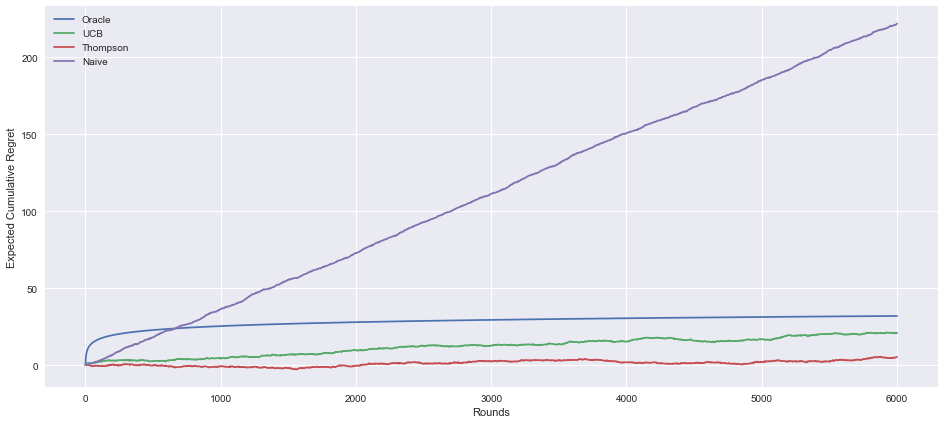

In [5]:
plt.figure(1, figsize=(16, 7))
x = np.arange(1, T+1)

# add oracle t -> C(p)log(t)
plt.plot(x, [oracle(t, MAB1, mu_max1) for t in xrange(1, T + 1)], label='Oracle')

plt.plot(x, expected_reg_UCB1, label='UCB')
plt.plot(x, expected_reg_TS, label='Thompson')
plt.plot(x, expected_reg_NS, label='Naive')
plt.xlabel('Rounds')
plt.ylabel('Expected Cumulative Regret')
plt.legend()
plt.show()

As we can see for a small complexity (`MAB1`) we are below the asymptotic lower bound for all strategies besides the naive one where we easily get stuck in a local optima, hence the increase in cumulated regret. On the graph above, it looks like the UCB model will go over the asymptotic lower bound for a higher $T > 6000$, whereas the Thompson Strategy cumulated regret increases slowly in comparison. Let's look at the same graph for a higher complexity MAB.

In [19]:
# Comparison of the regret on one run of the bandit algorithm
T = 5000
nb_iter = 50
UCB1 = UCB(mab=MAB2, t_max=T, rho=0.2)
TS = ThompsonSampling(mab=MAB2, t_max=T)
NS = NaiveStrategy(mab=MAB2, t_max=T)

# (Expected) regret curve for UCB and Thompson Sampling
expected_reg_UCB1, expected_reg_TS, expected_reg_NS = get_expected_regret(UCB1, TS, NS, T, nb_iter, mu_max2)

Running all 3 MAB algorithms for 50 iterations: 100%|██████████| 50/50 [00:15<00:00,  3.21it/s]


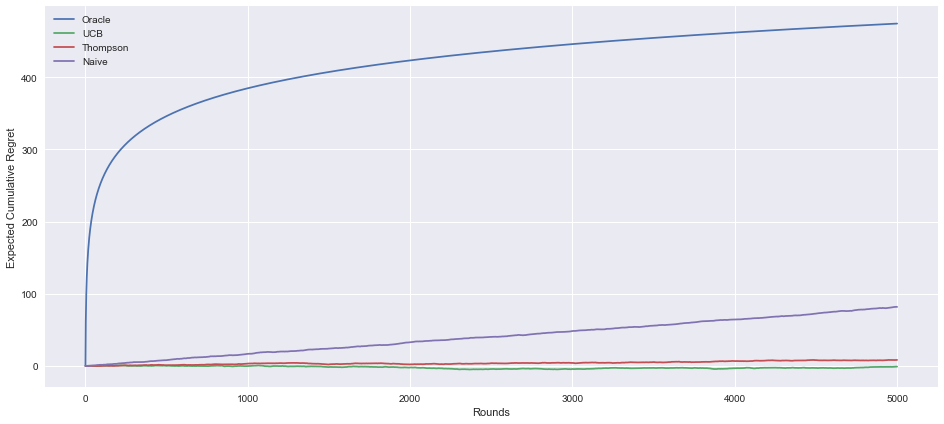

In [20]:
plt.figure(2, figsize=(16, 7))
x = np.arange(1, T+1)

# add oracle t -> C(p)log(t)
plt.plot(x, [oracle(t, MAB2, mu_max2) for t in xrange(1, T + 1)], label='Oracle')

plt.plot(x, expected_reg_UCB1, label='UCB')
plt.plot(x, expected_reg_TS, label='Thompson')
plt.plot(x, expected_reg_NS, label='Naive')
plt.xlabel('Rounds')
plt.ylabel('Expected Cumulative Regret')
plt.legend()
plt.show()

We actually see that with a more complex problem, we are even further down from the lower bound, which means that we actually perform well and the lower bound is too conservative for our example. 

### 1.2 Non-parametric bandits
---
For a non-Bernoulli or non-parametric distribution, the UCB algorithm doesn't change. For the Thompson sampling, we add a step since the rewards are not binary anymore, and the Beta distribution on the number of successes $S_a(t)$ and number of failures $N_a(t) - S_a(t)$ need to count binary rewards to be meaningful. 

To do that we add at each time `t`, after selecting an arm and getting a reward $r_t$, we run a Bernoulli trial with success probability equal to $r_t$ which will give us a binary output which we will use to update $S_a(t)$, we update $N_a(t)$ as we were doing previously. This more general method can also work for Bernoulli distribution naturally, since a Bernoulli trial with success probability equal to $r_t \in \{0, 1\}$ (output of a Bernoulli distribution) has always an output equal to $r_t$. 

Let's run the same algorithms for a different set of arms:

In [21]:
# MAB3
arm1 = arms.ArmBernoulli(0.25, random_state=random_state)
arm2 = arms.ArmExp(0.50, random_state=random_state)
arm3 = arms.ArmExp(0.80, random_state=random_state)
arm4 = arms.ArmBernoulli(0.60, random_state=random_state)
arm5 = arms.ArmBeta(0.50, 0.90, random_state=random_state)
arm6 = arms.ArmBeta(0.20, 0.30, random_state=random_state)
MAB3 = [arm1, arm2, arm3, arm4, arm5, arm6]

# bandit : set of arms
nb_arms3 = len(MAB1)
means3 = [el.mean for el in MAB3]

# Display the means of your bandit (to find the best)
print('MAB 3:')
print('means: {}'.format(means3))
mu_max3 = np.max(means3)

MAB 3:
means: [0.25, 0.45850591746320168, 0.43403377908390589, 0.6, 0.35714285714285715, 0.4]


In [30]:
# Comparison of the regret on one run of the bandit algorithm
T = 6000
nb_iter = 50
UCB1 = UCB(mab=MAB3, t_max=T, rho=0.2)
TS = ThompsonSampling(mab=MAB3, t_max=T)
NS = NaiveStrategy(mab=MAB3, t_max=T)

# (Expected) regret curve for UCB and Thompson Sampling
expected_reg_UCB1, expected_reg_TS, expected_reg_NS = get_expected_regret(UCB1, TS, NS, T, nb_iter, mu_max3)

Running all 3 MAB algorithms for 50 iterations: 100%|██████████| 50/50 [00:21<00:00,  2.35it/s]


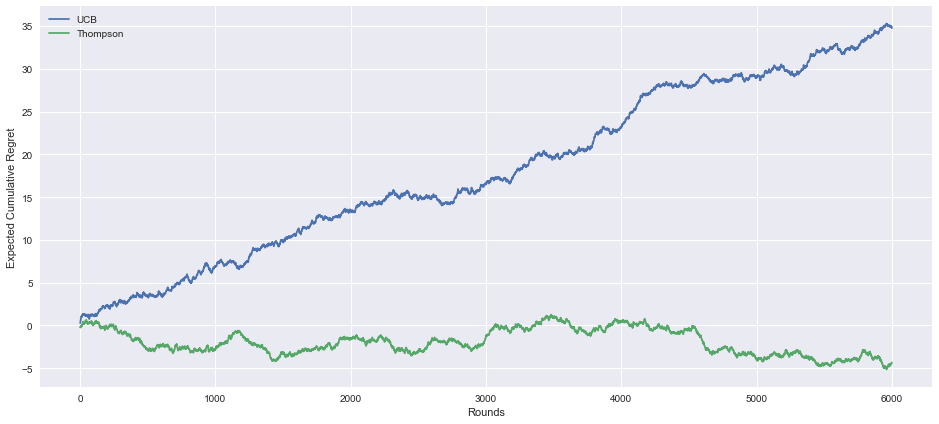

In [31]:
plt.figure(3, figsize=(16, 7))
x = np.arange(1, T+1)

plt.plot(x, expected_reg_UCB1, label='UCB')
plt.plot(x, expected_reg_TS, label='Thompson')
plt.xlabel('Rounds')
plt.ylabel('Expected Cumulative Regret')
plt.legend()
plt.show()

The complexity doesn't make sense anymore since the Kullback–Leibler divergence is not applied to Bernoulli distributions anymore but to more complex distributions, the paper suggested gives a generalized formula for the complexity and it's not just replacing the KL divergence of the Bernoulli distributions with the KL divergence of the new distributions, it's actually more complex than that (cf suggested paper).

It looks like the Thompson strategy works better usually that UCB, it might also depend on the real complexity of the problem. 

## Exercise 2
---


Let's run the linear model on the `ColdStartMovieLensModel` with some parameters that we previously tuned. I described the tuning of the parameter $\alpha = 300$ below. We chose $\lambda = 1$, it worked well so I didn't really tune $\lambda$. 

Simulating Random Strategy: 100%|██████████| 50/50 [00:31<00:00,  1.58it/s]


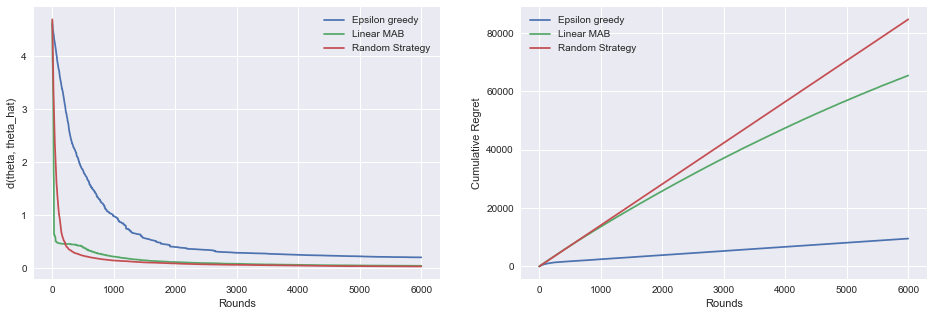

In [34]:
random_state = np.random.randint(0, 24532523)

model = ColdStartMovieLensModel(
    random_state=random_state,
    noise=0.1
)

T = 6000
nb_simu = 50
lambda_ = 1.
alpha = 300.

mean_norms_epsilon_greedy, mean_regret_epsilon_greedy = run_lin_mab(model, alg_name='Epsilon greedy',
                                                                    lambda_=lambda_, alpha=alpha,
                                                                    epsilon=0.1, T=T, nb_simu=nb_simu)

mean_norms_lin_mab, mean_regret_lin_mab = run_lin_mab(model, alg_name='Linear MAB',
                                                      lambda_=lambda_, alpha=alpha,
                                                      epsilon=0, T=T, nb_simu=nb_simu)

mean_norms_random, mean_regret_random = run_lin_mab(model, alg_name='Random Strategy',
                                                      lambda_=lambda_, alpha=alpha,
                                                      epsilon=1, T=T, nb_simu=nb_simu)

plt.figure(1)
plt.subplot(121)
plt.plot(mean_norms_epsilon_greedy, label='Epsilon greedy')
plt.plot(mean_norms_lin_mab, label='Linear MAB')
plt.plot(mean_norms_random, label='Random Strategy')
plt.ylabel('d(theta, theta_hat)')
plt.xlabel('Rounds')
plt.legend()

plt.subplot(122)
plt.plot(mean_regret_epsilon_greedy.cumsum(), label='Epsilon greedy')
plt.plot(mean_regret_lin_mab.cumsum(), label='Linear MAB')
plt.plot(mean_regret_random.cumsum(), label='Random Strategy')

plt.ylabel('Cumulative Regret')
plt.xlabel('Rounds')
plt.legend()
plt.show()

As expected, the random model gets a good performance in terms of convergence of $\theta^*$ since we explore more points in the space of movies, and we learn from them, however this means that we also pull some movies that are not relevant for the user, it is helpful to know that they are not useful for the user, however a smart strategy needs to take that fact into consideration and not pull those movies again. 

We can say that this is what the Linear MAB does when taking the $argmax$ of the most rewarding estimated movie $+$ a confidence bound that decreases the more we explore. However on this example the epsilon-greedy strategy is actually more efficient in terms of cumulated reward, and we can also see that the estimate of $\theta^*$ converges to the real value. 

But most likely, for a bigger horizon, the Linear Bandit cumulated regret might get under the Epsilon-greedy cumulated regret because the Linear Bandit cumulated regret seems to be logarithmic and the slope is decreasing. This actually makes sense because the epsilon greedy strategy is not effective for high horizons since we can suffer from random and very big regrets from time to time.  

Now let's look at the variation of the asymptotic norm $||\theta^* - \theta_{hat}||$ and cumulated regret with respect to alpha. We find the following results:

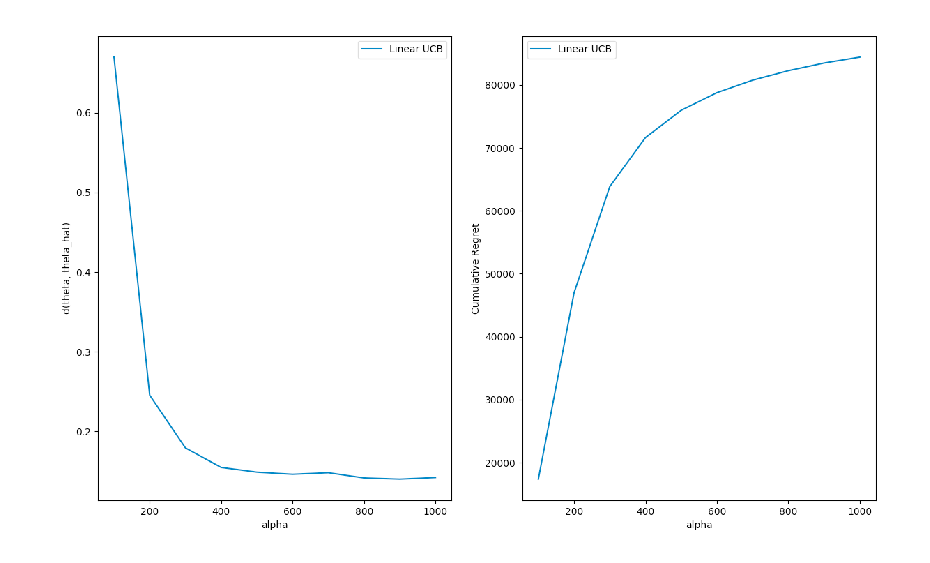

In [41]:
plt.figure(figsize=(16,16))
img = mpimg.imread('images/alpha_tuning.png')
plt.imshow(img)
plt.axis('off')
plt.show()

$\alpha=300$ seems to be a good trade-off between cumulated regret and error norm for $\theta$.